# COLAB PRO NOTEBOOK FOR CAPTION GENRATION

We have used InstructBLIP - Vicuna 7B model to generate the captions for the selected 100 images. This notebook uses A100 GPU runtime and goes upto 42 GB System RAM and 38.8 GB GPU RAM, so if we use lower GPU it crashes.  

This notebook is mainly built up on this page. [InstructBLIP for Conditional Generation](https://huggingface.co/docs/transformers/main/model_doc/instructblip#transformers.InstructBlipForConditionalGeneration)

To use this, please have a directory tree as follows

```

|-sample_data
|-the_hundread.csv
|-images
|---000000007149.jpg
|---000000009218.jpg
```
    


In [1]:
!pip install git+https://github.com/huggingface/transformers.git

!pip install accelerate

  Cloning https://github.com/huggingface/transformers.git to /tmp/pip-req-build-t8v3hafp
  Running command git clone --filter=blob:none --quiet https://github.com/huggingface/transformers.git /tmp/pip-req-build-t8v3hafp
  Resolved https://github.com/huggingface/transformers.git to commit a6484c89b9566333b7f9862e22f702070f47bbe9
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 4.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 104.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 74.7 MB/s eta 0:00:00
  Created wheel for transformers: filename=transformers-4.32.0.dev0-py3-none-any.whl size=7405694 sha256=1c01cb14c411e0c6a8e7ea5f413f324acc12391e60b5531e1198a295d70da2b5
  Stored in directory: /tmp/pip-ephem-wheel-cache-ddtrxezm/wheels/e7/9c/5b/e1a9c8007c343041e61cc484433d512ea9274272e3fcbe7c16

In [2]:
# LOAD THE MODEL
from transformers import InstructBlipProcessor, InstructBlipForConditionalGeneration
import torch

model = InstructBlipForConditionalGeneration.from_pretrained("Salesforce/instructblip-vicuna-7b")
processor = InstructBlipProcessor.from_pretrained("Salesforce/instructblip-vicuna-7b")

Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

In [3]:
# GET THE IMAGE LIST AND THE IMAGE LOCATIONS

import requests
from PIL import Image
import pandas as pd

image_list = []
df = pd.read_csv('the_hundread.csv')
for i in range(len(df)):
    num = df['image_id'].loc[i]
    # Pad with zeros to get exact location of image : example 000000214547.jpg
    pad = '%012d' % num
    im = 'images/' + str(pad) + '.jpg'
    # append to a list of images to be used for blip
    image_list.append(im)



## Check the generated caption in a single instance

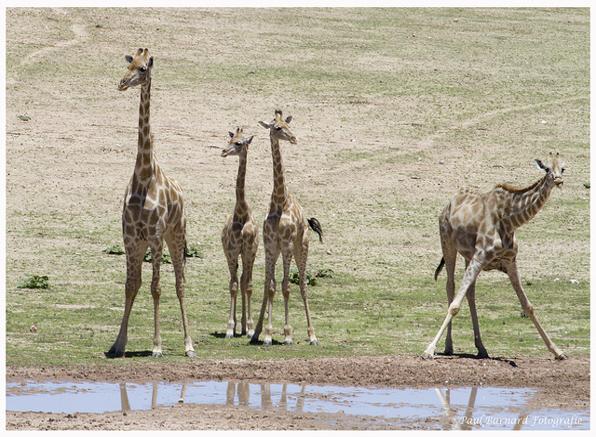

In [4]:
# DISPLAY A TEST IMAGE
raw_image = Image.open(image_list[0]).convert("RGB")
display(raw_image.resize((596, 437)))


In [5]:
device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)
device

'cuda'

In [6]:
prompt = "Give a detailed caption for this image"
inputs = processor(images=raw_image, text=prompt, return_tensors="pt").to(device)
outputs = model.generate(
    **inputs,
    do_sample=False,
    num_beams=5,
    max_length=256,
    min_length=1,
    top_p=0.9,
    repetition_penalty=1.5,
    length_penalty=1.0,
    temperature=1,
)
generated_text = processor.batch_decode(outputs, skip_special_tokens=True)[0].strip()
print(generated_text)

There is a group of four giraffes standing near a puddle of water in a grassy field. The giraffes appear to be socializing and interacting with each other, possibly drinking from the puddle. They are spread out across the scene, with one giraffe standing closer to the puddle and the other three positioned further away. The giraffes are of varying heights, with the closest one being the tallest and the furthest one being the shortest. In the background, there is another giraffe visible, but it is not as close to the puddle as the rest of the group. Overall, the scene depicts a lively and social gathering of giraffes in their natural habitat.


## Generate captions for all 100 images and append them to captions. THen add these captions in a text file along with questions and 4 options which will be used to prompt ChatGPT

In [8]:
captions = []

for i in range(len(image_list)):
  raw_image = Image.open(image_list[i]).convert("RGB")
  prompt = "Give a detailed caption for this image"
  inputs = processor(images=raw_image, text=prompt, return_tensors="pt").to(device)
  outputs = model.generate(
      **inputs,
      do_sample=False,
      num_beams=5,
      max_length=256,
      min_length=1,
      top_p=0.9,
      repetition_penalty=1.5,
      length_penalty=1.0,
      temperature=1,
  )
  generated_text = processor.batch_decode(outputs, skip_special_tokens=True)[0].strip()
  captions.append(generated_text)

In [9]:
import csv

with open('the_hundread.csv', 'r') as file:
    csv_reader = csv.DictReader(file)
    csv_data = list(csv_reader)

# Generate the output text
output_text = ''
for i in range(len(csv_data)):
    instance_text = f'i_{i+1}:{{\n'
    #instance_text += f'C_{i+1}: "{txt_data[i].strip()}";\n'
    # instance_text += f'C_{i+1}: [placeholder_'+str(i+1)+']\n'
    instance_text += f'C_{i+1}: "{captions[i]}";\n'
    instance_text += f'Q_{i+1}: "{csv_data[i]["question"]}";\n'
    instance_text += f'A_{i+1}:{{\n'
    instance_text += f'A_{i+1}_1: "{csv_data[i]["choices"].split(",")[0].strip()}";\n'
    instance_text += f'A_{i+1}_2: "{csv_data[i]["choices"].split(",")[1].strip()}";\n'
    instance_text += f'A_{i+1}_3: "{csv_data[i]["choices"].split(",")[2].strip()}";\n'
    instance_text += f'A_{i+1}_4: "{csv_data[i]["choices"].split(",")[3].strip()}";\n'
    instance_text += '}};\n\n'
    output_text += instance_text

# Write the output text to a new TXT file
with open('prompting_set_vicuna7B.txt', 'w') as file:
    file.write(output_text)
